In [1]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy 
import cartopy.crs as ccrs
import functions
import s3fs
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib as mpl
from scipy.interpolate import griddata
%matplotlib inline
%load_ext autoreload
%autoreload 2
# access and open the bucket
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0",
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [2]:
# list the available modeling data in the bucket
dir = 'escience2022/Ada/monthly'
files = [file for file in s3.ls(dir) if 'dmsos' in file ]

In [3]:
## for UKESM
#list of member-id that we average over
list_member_id = ['1', '2', '3', '4','8','9']
list_ds = []
for imember, member in enumerate(list_member_id):
    remote_files_UK = 's3://escience2022/Ada/monthly/dmsos_Omon_UKESM1-0-LL_historical_r'+member+'*.nc'
    remote_files_UK = s3.glob(remote_files_UK)
    fileset = [s3.open(file) for file in remote_files_UK]
    list_ds.append(xr.open_mfdataset(fileset, 
                                     combine='by_coords'))
## merge all the ensembles files 
ds_UKESM = xr.concat(list_ds,"member_id")
with ProgressBar():
    ds_dmsos_UKESM = ds_UKESM.dmsos.mean(dim=['member_id']).compute()

[########################################] | 100% Completed | 191.45 s


In [4]:
## for CNRM
#same list of member-id as in UKESM
list_member_id2 = ['1', '2', '3', '4','8','9']
list_ds_CN = []
for imember2, member2 in enumerate(list_member_id2):
    remote_files_CN = 's3://escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r'+member2+'*.nc'
    remote_files_CN = s3.glob(remote_files_CN)
    fileset2 = [s3.open(file) for file in remote_files_CN]
    list_ds_CN.append(xr.open_mfdataset(fileset2,combine="nested",compat="override"))
ds_CNRM = xr.concat(list_ds_CN,"member_id")
with ProgressBar():
    ds_dmsos_CNRM = ds_CNRM.dmsos.mean(dim=['member_id']).compute()

[########################################] | 100% Completed | 336.58 s


In [5]:
##  Greenland Sea for UKESM model
dmsosset_GLarea_UKESM=ds_dmsos_UKESM.where((ds_dmsos_UKESM.
                                              longitude >= -10)
                                           & (ds_dmsos_UKESM.
                                              longitude <= 10) 
                                           & (ds_dmsos_UKESM.
                                              latitude <= 85) 
                                           & (ds_dmsos_UKESM.
                                              latitude >= 70),
                         drop=True).compute()

In [6]:
dms_MeanAllHistrorical_UKESM_GL=dmsosset_GLarea_UKESM.mean(dim='time',
                                            keep_attrs=True).compute() 

In [7]:
## Laptev sea for UKESM
dmsosset_LapSarea_UKESM = ds_dmsos_UKESM.where((ds_dmsos_UKESM.
                                                longitude>=100) 
                                       & (ds_dmsos_UKESM.
                                          longitude<=160) 
                                       & (ds_dmsos_UKESM.
                                          latitude <= 80)  
                                       & (ds_dmsos_UKESM.
                                          latitude >= 70),
                         drop=True).compute()

In [8]:
dms_MeanAllHistrorical_UKESM_LapS = dmsosset_LapSarea_UKESM.mean(dim='time',
                                                    keep_attrs=True).compute() 

In [9]:
# Greenland Sea for CNRM model
dmsosset_GLarea_CNRM=ds_dmsos_CNRM.where((ds_dmsos_CNRM.lon >= -10)
                                           & (ds_dmsos_CNRM.lon <= 10) 
                                           & (ds_dmsos_CNRM.lat <= 85) 
                                           & (ds_dmsos_CNRM.lat >= 70),
                         drop=True).compute()

In [10]:
dms_MeanAllHistrorical_CNRM_GL = dmsosset_GLarea_CNRM.mean(dim='time',
                                            keep_attrs=True).compute() 

In [11]:
# Laptev Sea Sea for CNRM model
dmsosset_LapSarea_CNRM=ds_dmsos_CNRM.where((ds_dmsos_CNRM.
                                            lon >= 100)
                                           & (ds_dmsos_CNRM.
                                              lon <= 160) 
                                           & (ds_dmsos_CNRM.
                                              lat <= 80) 
                                           & (ds_dmsos_CNRM.
                                              lat >= 70),
                         drop=True).compute()

In [12]:
dms_MeanAllHistrorical_CNRM_LapS = dmsosset_LapSarea_CNRM.mean(dim='time',
                                                keep_attrs=True).compute() 

In [31]:
def plot_map_2panels(lon1,lat1,data1,title1,lon2,lat2,data2,title2,extent):
    mpl.rcParams.update({'font.size':10})
    
    fig, ax = plt.subplots(1,2,figsize=(6,5),subplot_kw={'projection'
                :ccrs.NorthPolarStereo()})
    MapL=ax[0].pcolormesh(lon1,lat1,data1,
        vmin=0,vmax=2.0e-6,          
        transform=ccrs.PlateCarree(),
            )
    ax[0].add_feature(cartopy.feature.LAND, zorder=1, 
                        edgecolor='black')
    ax[0].set_title(title1, fontsize = 10)
    ax[0].gridlines(draw_labels=True)
    ax[0].coastlines()
    ax[0].set_extent(extent, ccrs.PlateCarree())
    ax[0].add_feature(cartopy.feature.RIVERS, zorder=1, 
                  edgecolor='blue')

#    title1=ax[0].set_title('A) GLS - UKESM', fontsize = 10)
#    extent1 = ax[0].set_extent([-20, 20,65,90], ccrs.PlateCarree())
    MapR=ax[1].pcolormesh(lon2,lat2,data2, 
        vmin=0,vmax=2.0e-6,          
        transform=ccrs.PlateCarree(),
            )
    ax[1].add_feature(cartopy.feature.LAND, zorder=1, 
                edgecolor='black')
    ax[1].gridlines(draw_labels=True)
    ax[1].coastlines()
    ax[1].set_extent(extent, ccrs.PlateCarree())
    ax[1].set_title(title2, fontsize = 10)
    ax[1].add_feature(cartopy.feature.RIVERS, zorder=1, 
                  edgecolor='blue')

#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
    axins = inset_axes(ax[1],
            width="6%",  
            height="100%",
            loc='right',
            borderpad=-3
                )

# add colorbar from ax
    cbar = fig.colorbar(MapL, cax=axins, orientation='vertical')
    cbar = fig.colorbar(MapR, cax=axins, orientation='vertical')
# style(axins)
    cbar.set_label('DMSOS (mol/m$^{-3}$)', fontsize=10)

# thickness of spines around the colorbar
    cbar.outline.set_linewidth(1)
    fig.tight_layout()
    def style_cbar(ax):
        ax.tick_params(axis='both', which='major', 
                   labelsize=10)
        ax.tick_params(axis='both', which='both', 
                   length=8, width=1, direction='out')
    style_cbar(axins)
    return (MapL,MapR)

/tmp/ipykernel_3844/1208062809.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


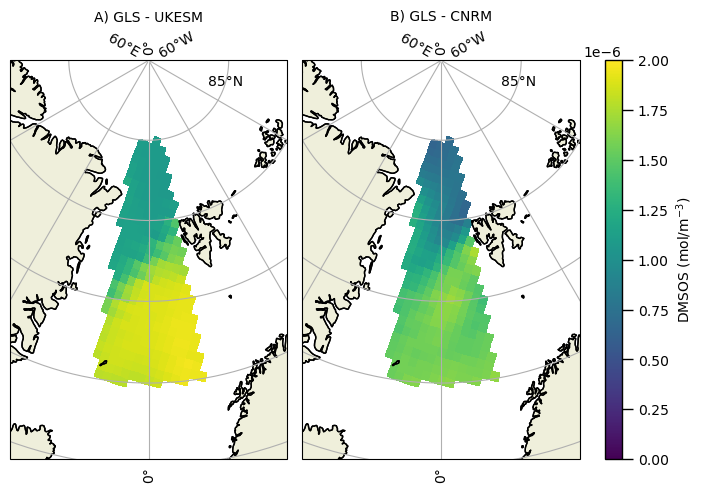

In [32]:
## plotting fig 1 
#extent = ax[0].set_extent([-20, 20,65,90], ccrs.PlateCarree())
fig1 = plot_map_2panels(dms_MeanAllHistrorical_UKESM_GL.longitude,
                        dms_MeanAllHistrorical_UKESM_GL.latitude,
                        dms_MeanAllHistrorical_UKESM_GL,
                        'A) GLS - UKESM',
                        dms_MeanAllHistrorical_CNRM_GL.lon,
                        dms_MeanAllHistrorical_CNRM_GL.lat,
                        dms_MeanAllHistrorical_CNRM_GL,
                        'B) GLS - CNRM',
                        [-20, 20,65,90])

/tmp/ipykernel_3844/1208062809.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


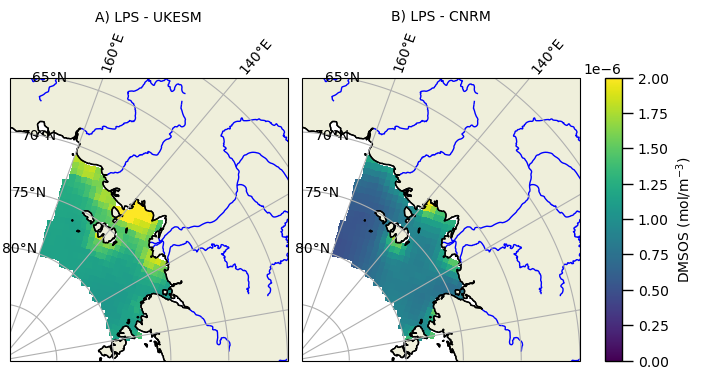

In [33]:
## plotting fig 2 
fig1 = plot_map_2panels(dms_MeanAllHistrorical_UKESM_LapS.longitude,
                        dms_MeanAllHistrorical_UKESM_LapS.latitude,
                        dms_MeanAllHistrorical_UKESM_LapS,
                        'A) LPS - UKESM',
                        dms_MeanAllHistrorical_CNRM_LapS.lon,
                        dms_MeanAllHistrorical_CNRM_LapS.lat,
                        dms_MeanAllHistrorical_CNRM_LapS, 
                        'B) LPS - CNRM',
                        [90,170,65,85])

In [ ]:
mpl.rcParams.update({'font.size':10})
fig, ax = plt.subplots(1,2,figsize=(6,5),subplot_kw={'projection'
                                        :ccrs.NorthPolarStereo()})
ax[0].set_extent([-20, 20,65,90], ccrs.PlateCarree())
ax[1].set_extent([-20, 20,65,90], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_MeanAllHistrorical_UKESM_GL.longitude,
                       dms_MeanAllHistrorical_UKESM_GL.latitude,
              dms_MeanAllHistrorical_UKESM_GL, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, 
                  edgecolor='black')
ax[0].set_title('A) GLS - UKESM', fontsize = 10)
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()

pl_CNRM=ax[1].pcolormesh(dms_MeanAllHistrorical_CNRM_GL.lon,
                       dms_MeanAllHistrorical_CNRM_GL.lat,
              dms_MeanAllHistrorical_CNRM_GL, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, 
                  edgecolor='black')
ax[1].set_title('B) GLS - CNRM', fontsize = 10)
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[1],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_UKESM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMSOS (mol/m$^{-3}$)', fontsize=10)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', 
                   labelsize=10)
    ax.tick_params(axis='both', which='both', 
                   length=8, width=1, direction='out')

style_cbar(axins)

In [ ]:
mpl.rcParams.update({'font.size':10})
fig, ax = plt.subplots(1,3,figsize=(8,8),subplot_kw={'projection'
                                        :ccrs.NorthPolarStereo()})
ax[0].set_extent([-20, 20,65,90], ccrs.PlateCarree())
ax[1].set_extent([-20, 20,65,90], ccrs.PlateCarree())
ax[2].set_extent([-20, 20,65,90], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_Mean2003to2014_GLS_UKESM.longitude,
                       dms_Mean2003to2014_GLS_UKESM.latitude,
              dms_Mean2003to2014_GLS_UKESM, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('A) 2003-2014 - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()
ax[0].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')
pl_CNRM=ax[1].pcolormesh(dms_Mean2003to2014_GLS_CNRM.lon,
                         dms_Mean2003to2014_GLS_CNRM.lat,
                         dms_Mean2003to2014_GLS_CNRM, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('B) 2003-2014- CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
ax[1].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')

pl_Obs=ax[2].pcolormesh(dmsObs_Mean_2003to2014_GLS.lon,
                        dmsObs_Mean_2003to2014_GLS.lat,
                        dmsObs_Mean_2003to2014_GLS*1.0e-6,
    vmin=0,vmax=2.0e-6,          
        )
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[2].set_title('C) 2003-2014 - Obs MOD-AQ')
ax[2].gridlines(draw_labels=True)
ax[2].coastlines()
ax[2].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[2],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_UKESM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_Obs, cax=axins, orientation='vertical')
cbar.set_label('DMSOS (mol/m$^{-3}$)')
cbar.outline.set_linewidth(1)
fig.tight_layout()
style_cbar(axins)